In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import time

import torch
import torch.nn as nn
import torchvision.transforms as tvtf
import torchvision.utils as tvutils

import gan_model_definitions

In [2]:
image_size = 128
image_content_types = ['Leaf', 'Flower', 'Entire', 'Fruit', 'Stem']

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super(ImageDataset, self).__init__()
        self.image_paths = df.jpg.tolist()
        self.image_content = np.eye(len(image_content_types))[df.content.map(image_content_types.index)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.image_paths[idx])        
        image_tensor = tvtf.Compose([
            tvtf.Resize(image_size),
            tvtf.CenterCrop(image_size),
            tvtf.ToTensor(),
            tvtf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image)
        
        image_content_tensor = torch.FloatTensor(self.image_content[idx])

        return image_tensor, image_content_tensor

In [3]:
device = torch.device("cuda:0")

dataset = ImageDataset(pd.read_json("data/data.json"))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True, num_workers = 2)

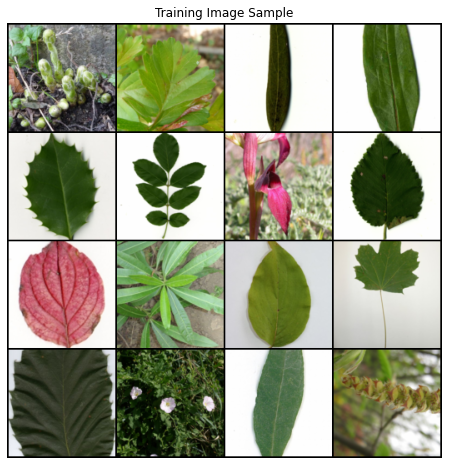

In [4]:
sample_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Image Sample")
plt.imshow(np.transpose(
    tvutils.make_grid(sample_batch[0][:16], padding = 2, normalize = True, nrow = 4),
    (1, 2, 0)
))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Create the generator
netG = gan_model_definitions.Generator(image_content_types).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

print(netG)

Generator(
  (image_conv): Sequential(
    (0): ParametrizedConvTranspose2d(
      200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ParametrizedConvTranspose2d(
      1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ParametrizedConvTranspose2d(
      512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )


In [7]:
netD = gan_model_definitions.Discriminator(image_content_types).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

print(netD)

Discriminator(
  (image_conv): Sequential(
    (0): ParametrizedConv2d(
      3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ParametrizedConv2d(
      64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ParametrizedConv2d(
      128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Le

In [8]:
# Learning rate for G optimizer
g_lr = 0.0001

# Learning rate for D optimizer
d_lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.7

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(16, gan_model_definitions.nz, 1, 1, device = device)

# Establish convention for real and fake labels during training
# Use 0.9 instead of 1.0 (label smoothing)
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr = g_lr, betas = (beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr = d_lr, betas = (beta1, 0.999))

In [ ]:
num_epochs = 200

# Training Loop

# Lists to keep track of progress
img_list = []
class_list = []
G_losses = []
D_losses = []
iters = 0

start = time.time()
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (image, image_class) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu_image = image.to(device)
        real_cpu_class = image_class.to(device)

        b_size = real_cpu_image.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float, device = device)
        # Forward pass real batch through D
        output = netD(real_cpu_image, real_cpu_class).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, gan_model_definitions.nz, 1, 1, device = device)
        # Generate fake image batch with G
        fake_image, fake_class = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake_image.detach(), fake_class.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake_image, fake_class).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%3d/%3d][%3d/%3d]  Loss_D: %.3f  Loss_G: %.3f  D(x): %.3f  D(G(z)): %.3f/%.3f  [Elapsed: %5ds]'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, time.time() - start))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake_image, fake_class = netG(fixed_noise)
            img_list.extend(fake_image.detach().cpu())
            class_list.extend(fake_class.detach().cpu().argmax(1))

        iters += 1

[  0/200][  0/190]  Loss_D: 1.369  Loss_G: 1.312  D(x): 0.449  D(G(z)): 0.444/0.240  [Elapsed:     1s]
[  0/200][ 50/190]  Loss_D: 0.606  Loss_G: 1.443  D(x): 0.790  D(G(z)): 0.211/0.207  [Elapsed:    21s]
[  0/200][100/190]  Loss_D: 0.578  Loss_G: 1.547  D(x): 0.794  D(G(z)): 0.191/0.183  [Elapsed:    40s]
[  0/200][150/190]  Loss_D: 0.482  Loss_G: 1.902  D(x): 0.823  D(G(z)): 0.124/0.123  [Elapsed:    61s]
[  1/200][  0/190]  Loss_D: 0.469  Loss_G: 1.961  D(x): 0.830  D(G(z)): 0.116/0.115  [Elapsed:    78s]
[  1/200][ 50/190]  Loss_D: 0.454  Loss_G: 2.030  D(x): 0.841  D(G(z)): 0.107/0.106  [Elapsed:    99s]
[  1/200][100/190]  Loss_D: 0.440  Loss_G: 2.162  D(x): 0.850  D(G(z)): 0.099/0.092  [Elapsed:   119s]
[  1/200][150/190]  Loss_D: 0.416  Loss_G: 2.278  D(x): 0.861  D(G(z)): 0.081/0.080  [Elapsed:   140s]
[  2/200][  0/190]  Loss_D: 0.410  Loss_G: 2.334  D(x): 0.867  D(G(z)): 0.076/0.075  [Elapsed:   156s]
[  2/200][ 50/190]  Loss_D: 0.402  Loss_G: 2.406  D(x): 0.870  D(G(z)): 0

[ 20/200][  0/190]  Loss_D: 0.828  Loss_G: 3.143  D(x): 0.888  D(G(z)): 0.365/0.035  [Elapsed:  1587s]
[ 20/200][ 50/190]  Loss_D: 0.552  Loss_G: 1.824  D(x): 0.714  D(G(z)): 0.090/0.150  [Elapsed:  1607s]
[ 20/200][100/190]  Loss_D: 0.458  Loss_G: 2.907  D(x): 0.833  D(G(z)): 0.093/0.044  [Elapsed:  1628s]
[ 20/200][150/190]  Loss_D: 0.622  Loss_G: 1.713  D(x): 0.731  D(G(z)): 0.145/0.184  [Elapsed:  1649s]
[ 21/200][  0/190]  Loss_D: 1.080  Loss_G: 3.426  D(x): 0.913  D(G(z)): 0.511/0.023  [Elapsed:  1666s]
[ 21/200][ 50/190]  Loss_D: 0.412  Loss_G: 3.463  D(x): 0.840  D(G(z)): 0.057/0.023  [Elapsed:  1687s]
[ 21/200][100/190]  Loss_D: 0.724  Loss_G: 2.220  D(x): 0.830  D(G(z)): 0.286/0.098  [Elapsed:  1708s]
[ 21/200][150/190]  Loss_D: 0.774  Loss_G: 2.683  D(x): 0.512  D(G(z)): 0.038/0.057  [Elapsed:  1730s]
[ 22/200][  0/190]  Loss_D: 0.854  Loss_G: 1.566  D(x): 0.491  D(G(z)): 0.044/0.207  [Elapsed:  1747s]
[ 22/200][ 50/190]  Loss_D: 0.611  Loss_G: 2.533  D(x): 0.883  D(G(z)): 0

[ 40/200][  0/190]  Loss_D: 0.556  Loss_G: 2.336  D(x): 0.678  D(G(z)): 0.049/0.097  [Elapsed:  3183s]
[ 40/200][ 50/190]  Loss_D: 0.585  Loss_G: 3.006  D(x): 0.960  D(G(z)): 0.192/0.041  [Elapsed:  3204s]
[ 40/200][100/190]  Loss_D: 0.594  Loss_G: 2.527  D(x): 0.663  D(G(z)): 0.070/0.079  [Elapsed:  3225s]
[ 40/200][150/190]  Loss_D: 0.556  Loss_G: 2.810  D(x): 0.677  D(G(z)): 0.062/0.054  [Elapsed:  3246s]
[ 41/200][  0/190]  Loss_D: 0.356  Loss_G: 3.538  D(x): 0.906  D(G(z)): 0.025/0.022  [Elapsed:  3263s]
[ 41/200][ 50/190]  Loss_D: 0.446  Loss_G: 2.887  D(x): 0.913  D(G(z)): 0.104/0.046  [Elapsed:  3284s]
[ 41/200][100/190]  Loss_D: 0.415  Loss_G: 3.336  D(x): 0.923  D(G(z)): 0.073/0.027  [Elapsed:  3304s]
[ 41/200][150/190]  Loss_D: 0.361  Loss_G: 3.038  D(x): 0.885  D(G(z)): 0.027/0.043  [Elapsed:  3325s]
[ 42/200][  0/190]  Loss_D: 0.438  Loss_G: 2.963  D(x): 0.888  D(G(z)): 0.096/0.043  [Elapsed:  3342s]
[ 42/200][ 50/190]  Loss_D: 0.393  Loss_G: 2.184  D(x): 0.870  D(G(z)): 0

[ 60/200][  0/190]  Loss_D: 0.444  Loss_G: 4.176  D(x): 0.740  D(G(z)): 0.015/0.012  [Elapsed:  4781s]
[ 60/200][ 50/190]  Loss_D: 0.486  Loss_G: 3.809  D(x): 0.948  D(G(z)): 0.126/0.016  [Elapsed:  4802s]
[ 60/200][100/190]  Loss_D: 0.549  Loss_G: 3.847  D(x): 0.927  D(G(z)): 0.186/0.017  [Elapsed:  4824s]
[ 60/200][150/190]  Loss_D: 0.362  Loss_G: 3.440  D(x): 0.873  D(G(z)): 0.021/0.027  [Elapsed:  4845s]
[ 61/200][  0/190]  Loss_D: 0.442  Loss_G: 3.292  D(x): 0.783  D(G(z)): 0.050/0.031  [Elapsed:  4863s]
[ 61/200][ 50/190]  Loss_D: 0.418  Loss_G: 3.514  D(x): 0.789  D(G(z)): 0.032/0.024  [Elapsed:  4885s]
[ 61/200][100/190]  Loss_D: 0.379  Loss_G: 3.407  D(x): 0.917  D(G(z)): 0.044/0.027  [Elapsed:  4907s]
[ 61/200][150/190]  Loss_D: 0.546  Loss_G: 3.285  D(x): 0.951  D(G(z)): 0.170/0.031  [Elapsed:  4929s]
[ 62/200][  0/190]  Loss_D: 0.779  Loss_G: 2.264  D(x): 0.531  D(G(z)): 0.079/0.105  [Elapsed:  4948s]
[ 62/200][ 50/190]  Loss_D: 0.471  Loss_G: 3.924  D(x): 0.896  D(G(z)): 0

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize = (16, 16))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(
    tvutils.make_grid(real_batch[0][:16], normalize = True, nrow = 4),
    (1, 2, 0))
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(
    tvutils.make_grid(img_list[-16:], padding = 2, normalize = True, nrow = 4),
    (1, 2, 0)
))

plt.show()

In [ ]:
torch.save(netG.state_dict(), "models/128x128.pkl")